# Day 78 of 100 days of code

Much of the text in this notebook originates from the course [100 days of code](https://www.udemy.com/course/100-days-of-code) with Angela Yu. Answers to the challenges (code and text) is written by me. 

**Objective:** Do higher film budgets lead to more box office revenue? Should a movie studio spend more on a film to make more? Let's find out if there's a relationship using the movie budgets and financial performance data scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**. 

<img src=https://i.imgur.com/kq7hrEh.png height=150>


**Today you'll learn:**

- How to use a popular data visualisation library called **Seaborn**
- How to run and interpret a **linear regression with scikit-learn**
- How to **plot a regression line on a scatter plot** to visualise relationships in the data
- How to add a third dimension to a scatter plot to create a **bubble chart**
- How to cleverly use **floor division** // to convert your data

# Import Statements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
from sklearn.linear_model import LinearRegression  # pip install -U scikit-learn

# Notebook Presentation

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [3]:
data = pd.read_csv('cost_revenue_dirty.csv')
data[:5]

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,8/2/1915,The Birth of a Nation,"$110,000","$11,000,000","$10,000,000"
1,5140,5/9/1916,Intolerance,"$385,907",$0,$0
2,5230,12/24/1916,"20,000 Leagues Under the Sea","$200,000","$8,000,000","$8,000,000"
3,5299,9/17/1920,Over the Hill to the Poorhouse,"$100,000","$3,000,000","$3,000,000"
4,5222,1/1/1925,The Big Parade,"$245,000","$22,000,000","$11,000,000"


# Explore and Clean the Data

**Challenge**: Answer these questions about the dataset:

**1. How many rows and columns does the dataset contain?** (5391, 6)

**2. Are there any NaN values present?** No

**3. Are there any duplicate rows?** No

**4. What are the data types of the columns?** See below

In [4]:
print(data.shape)
print("Any NaN values?", data.isna().values.any())  # No NaN values
print("Any dupilcated rows?", data.duplicated().values.any())  # No duplicated rows
data.dtypes

(5391, 6)
Any NaN values? False
Any dupilcated rows? False


Rank                      int64
Release_Date             object
Movie_Title              object
USD_Production_Budget    object
USD_Worldwide_Gross      object
USD_Domestic_Gross       object
dtype: object

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   5391 non-null   int64 
 1   Release_Date           5391 non-null   object
 2   Movie_Title            5391 non-null   object
 3   USD_Production_Budget  5391 non-null   object
 4   USD_Worldwide_Gross    5391 non-null   object
 5   USD_Domestic_Gross     5391 non-null   object
dtypes: int64(1), object(5)
memory usage: 252.8+ KB


### Data Type Conversions

**Challenge**: Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`. 
<br>
<br>
Note that *domestic* in this context refers to the United States.

In [6]:
columns_to_clean = ["USD_Production_Budget", "USD_Worldwide_Gross", "USD_Domestic_Gross"]
# Remove "$" and ","
data[columns_to_clean] = data[columns_to_clean].replace(r"\$|\,", "", regex=True)
data[:5]

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,8/2/1915,The Birth of a Nation,110000,11000000,10000000
1,5140,5/9/1916,Intolerance,385907,0,0
2,5230,12/24/1916,"20,000 Leagues Under the Sea",200000,8000000,8000000
3,5299,9/17/1920,Over the Hill to the Poorhouse,100000,3000000,3000000
4,5222,1/1/1925,The Big Parade,245000,22000000,11000000


In [7]:
# Convert the budget and revenue columns to numeric type
for col in columns_to_clean:
    data[col] = pd.to_numeric(data[col])
data.dtypes

Rank                      int64
Release_Date             object
Movie_Title              object
USD_Production_Budget     int64
USD_Worldwide_Gross       int64
USD_Domestic_Gross        int64
dtype: object

**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type. 

In [8]:
data["Release_Date"] = pd.to_datetime(data["Release_Date"], format="%m/%d/%Y")
print(data.dtypes)
data[:2]

Rank                              int64
Release_Date             datetime64[ns]
Movie_Title                      object
USD_Production_Budget             int64
USD_Worldwide_Gross               int64
USD_Domestic_Gross                int64
dtype: object


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000
1,5140,1916-05-09,Intolerance,385907,0,0


### Descriptive Statistics

We see from the description table that there are 5391 movies in the dataset. They are ranked from 1 to 5391. 

**Challenge**: 

**1. What is the average production budget of the films in the data set?**  

- $31 million.

**2. What is the average worldwide gross revenue (_no: gjennomsnittlig bruttoinntekt/omsetning på verdensbasis_) of films?** 

- About $88.9 million.

**3. What were the minimums for worldwide and domestic revenue?** 

- $0 for both worldwide and domestic revenue.

**4. Are the bottom 25% of films actually profitable or do they lose money?** 

- To answer the question I assume that "the bottom 25% of films" refers to the 25% lowest (worst) ranked films, i.e., movies with rank 4044 or higher. Se further explanation and code below.

- The soultion for this challenge (provided in the course) treats "the bottom quartile" as a group of films: "[...] But quite a lot of films lose money too. In fact, all the films in the bottom quartile lose money, since the average cost is $5 million and they only bring in $3.8m in worldwide revenue". This is not a correct interpretation of the description table below (made with `.describe()`). In this statement it is assumed that the values in the"25%" (25th percentile) row are related to each other, but the percentile values are calculated for each column in the DataFrame and are not related to any spesifick group of films. This becomes clear if we look at the "min" row, which gives us the lowest occuring value in each column in the DataFrame. These values "belongs" (or could belong) to a different film. The minimum value for "Rank" is 1, which is the best possible rank and it belongs to the movie "Avatar", while the lowest value in the column "USD_Production_Budget" is $1100, which is the budget of the movie "My Date With Drew".

**5. What are the highest production budget and highest worldwide gross revenue of any film?** 

- The highest production budget is $425M, and the highest worldwide gross revenue is about $2.8 billion.

**6. How much revenue did the lowest and highest budget films make?** 

- The movie with the lowest production budget ($1,100) is "My Date With Drew" which made $181,041.
- The movie with the highest production budget ($425,000,000) is "Avatar" which made almost $2.8 billion.

In [9]:
data.describe()

,Rank,Release_Date,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
count,"5,391.00",5391,"5,391.00","5,391.00","5,391.00"
mean,"2,696.00",2003-09-19 15:02:02.203672704,"31,113,737.58","88,855,421.96","41,235,519.44"
min,1.00,1915-08-02 00:00:00,"1,100.00",0.00,0.00
25%,"1,348.50",1999-12-02 12:00:00,"5,000,000.00","3,865,206.00","1,330,901.50"
50%,"2,696.00",2006-06-23 00:00:00,"17,000,000.00","27,450,453.00","17,192,205.00"
75%,"4,043.50",2011-11-23 00:00:00,"40,000,000.00","96,454,455.00","52,343,687.00"
max,"5,391.00",2020-12-31 00:00:00,"425,000,000.00","2,783,918,982.00","936,662,225.00"
std,"1,556.39",NaN,"40,523,796.88","168,457,757.00","66,029,346.27"


In [10]:
data[data["Rank"] == 1]

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
3529,1,2009-12-18,Avatar,425000000,2783918982,760507625


By adding the column "USD_Profit" (difference between production budget and the worldwide gross revenue) we see that the **average profit is $57,741,684.38**.

In [11]:
data["USD_Profit"] = data["USD_Worldwide_Gross"] - data["USD_Production_Budget"]
print(data[:3].to_string())
data.describe()

   Rank Release_Date                   Movie_Title  USD_Production_Budget  USD_Worldwide_Gross  USD_Domestic_Gross  USD_Profit
0  5293   1915-08-02         The Birth of a Nation                 110000             11000000            10000000    10890000
1  5140   1916-05-09                   Intolerance                 385907                    0                   0     -385907
2  5230   1916-12-24  20,000 Leagues Under the Sea                 200000              8000000             8000000     7800000


,Rank,Release_Date,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,USD_Profit
count,"5,391.00",5391,"5,391.00","5,391.00","5,391.00","5,391.00"
mean,"2,696.00",2003-09-19 15:02:02.203672704,"31,113,737.58","88,855,421.96","41,235,519.44","57,741,684.38"
min,1.00,1915-08-02 00:00:00,"1,100.00",0.00,0.00,"-175,000,000.00"
25%,"1,348.50",1999-12-02 12:00:00,"5,000,000.00","3,865,206.00","1,330,901.50","-2,244,775.00"
50%,"2,696.00",2006-06-23 00:00:00,"17,000,000.00","27,450,453.00","17,192,205.00","8,122,000.00"
75%,"4,043.50",2011-11-23 00:00:00,"40,000,000.00","96,454,455.00","52,343,687.00","59,518,660.00"
max,"5,391.00",2020-12-31 00:00:00,"425,000,000.00","2,783,918,982.00","936,662,225.00","2,358,918,982.00"
std,"1,556.39",NaN,"40,523,796.88","168,457,757.00","66,029,346.27","140,972,329.93"


**Question 4. Are the bottom 25% of films actually profitable or do they lose money?**

I assume that "the bottom 25% of films" refers to the 25% lowest (worst) ranked films, i.e., movies with rank 4044 or higher (value). This number is the 75th percentile for the column "Rank" (rounded up from 4043.5), which tells us that 75% of the movies have a "Rank" value equal to 4043.5 or lower (i.e. higher ranked, because rank number 1 is best), and therefore 25% of the movies must have a worse rank (higher numerical value).

When looking at the description table for a DataFrame consisting of the 25% lowest (worst) ranked movies, we see that the average profit is about $7.4M, while the median profit is close to -$90K. This tells us that the lowest ranked movies could be profitable, but most of them (more than 50%) are not.

In [12]:
data["Rank"].duplicated().any()  
# No movies are at the same rank. Good to know.

False

In [13]:
# Create a DataFrame with the 25% lowest ranked films

# 75th percentile value in the "Rank" column
rank_q75 = data["Rank"].quantile(0.75)
print(f"{rank_q75 = }")

# Filter data: include rows where "Rank" is equal or higher than the 75th percentile.
bottom_25p_movies = data.loc[data["Rank"] >= rank_q75]  
print(f"{bottom_25p_movies.shape = }")

bottom_25p_movies.describe()

rank_q75 = 4043.5
bottom_25p_movies.shape = (1348, 7)


,Rank,Release_Date,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,USD_Profit
count,"1,348.00",1348,"1,348.00","1,348.00","1,348.00","1,348.00"
mean,"4,717.50",2001-04-12 12:23:30.089020800,"1,874,027.95","9,299,180.18","5,982,015.03","7,425,152.23"
min,"4,044.00",1915-08-02 00:00:00,"1,100.00",0.00,0.00,"-5,000,000.00"
25%,"4,380.75",1999-03-13 18:00:00,"500,000.00","6,159.50",0.00,"-1,200,000.00"
50%,"4,717.50",2007-04-22 00:00:00,"1,500,000.00","636,005.50","257,153.50","-89,881.50"
75%,"5,054.25",2013-01-06 18:00:00,"3,000,000.00","7,146,872.50","4,051,902.25","4,713,997.50"
max,"5,391.00",2017-08-25 00:00:00,"5,000,000.00","390,525,192.00","198,680,470.00","386,625,192.00"
std,389.28,NaN,"1,471,007.51","27,187,087.57","16,655,558.08","27,034,074.86"


**Question 6. How much revenue did the lowest and highest budget films make?**

In [14]:
low_budg_films = data.iloc[data['USD_Production_Budget'].idxmin()]
print(f"\nThe movie with the lowest production budget (${'{:,.0f}'.format(low_budg_films['USD_Production_Budget'])}) is \"{low_budg_films['Movie_Title']}\" which made ${'{:,.0f}'.format(low_budg_films['USD_Worldwide_Gross'])}.")


The movie with the lowest production budget ($1,100) is "My Date With Drew" which made $181,041.


In [15]:
high_budj_movie = data.iloc[data['USD_Production_Budget'].idxmax()]
print(f"\nThe movie with the highest production budget (${'{:,.0f}'.format(high_budj_movie['USD_Production_Budget'])}) is \"{high_budj_movie['Movie_Title']}\" which made ${'{:,.0f}'.format(high_budj_movie['USD_Worldwide_Gross'])}.")


The movie with the highest production budget ($425,000,000) is "Avatar" which made $2,783,918,982.


# Investigating the Zero Revenue Films

**Challenge** How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

- 512 films made $0 in the US.

On the first try of getting the top 5 list of zero-grossing films with the highest budget, we get the following: "Singularity", "Aquaman", "A Wrinkle in Time", "Amusement Park" and "Don Gato, el inicio de la pandilla". However, all the films except "Don Gato, el inicio de la pandilla" were released after this dataset was scraped (May 2018), and therefore their revenue could not have been known at the time. A good example is Aquaman, which according to [wikipedia](https://en.wikipedia.org/wiki/Aquaman_(film)#:~:text=While%20the%20film%20received%20mixed,grossing%20film%20of%20all%20time.) was first released in November 2018, _"grossed $1.152 billion worldwide, making it the highest-grossing DCEU film, the highest-grossing film based on a DC Comics character, the fifth-highest-grossing film of 2018, and the 20th highest-grossing film of all time."_

In [16]:
zero_rev_films = data[data["USD_Domestic_Gross"] == 0]
print(zero_rev_films.shape)
zero_rev_films[:2]

(512, 7)


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,USD_Profit
1,5140,1916-05-09,Intolerance,385907,0,0,-385907
6,4630,1927-12-08,Wings,2000000,0,0,-2000000


In [17]:
zero_rev_films.sort_values("USD_Production_Budget", ascending=False)[:5]

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,USD_Profit
5388,96,2020-12-31,Singularity,175000000,0,0,-175000000
5387,126,2018-12-18,Aquaman,160000000,0,0,-160000000
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0,-103000000
5385,366,2018-10-08,Amusement Park,100000000,0,0,-100000000
5090,556,2015-12-31,"Don Gato, el inicio de la pandilla",80000000,4547660,0,-75452340


To take the release date into account, we must at least exclude films released after our data was collected (May 1st 2018). Furthermore, we must bear in mind that it might not be meaningfull to compare revenue for films released close up to May 2018 with much older films.

In [18]:
zero_rev_films2 = data.loc[
    (data["USD_Domestic_Gross"] == 0) &
    (data["Release_Date"] < "2018-05-01")
]
print(zero_rev_films2.shape)
zero_rev_films2[:2]

(505, 7)


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,USD_Profit
1,5140,1916-05-09,Intolerance,385907,0,0,-385907
6,4630,1927-12-08,Wings,2000000,0,0,-2000000


In [19]:
zero_rev_films2.sort_values("USD_Production_Budget", ascending=False)[:5]

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,USD_Profit
5090,556,2015-12-31,"Don Gato, el inicio de la pandilla",80000000,4547660,0,-75452340
4294,566,2012-12-31,Astérix et Obélix: Au service de Sa Majesté,77600000,60680125,0,-16919875
5338,879,2017-04-08,The Dark Tower,60000000,0,0,-60000000
5058,880,2015-11-12,The Ridiculous 6,60000000,0,0,-60000000
4295,1230,2012-12-31,Foodfight!,45000000,73706,0,-44926294


"Don Gato, el inicio de la pandilla" is Spanish (I think), and "Astérix et Obélix: Au service de Sa Majesté" is French, and we can assume that they were released in French and Spanish speaking countries respectively, not making a single dolar in the US. That make sense.

However, at [the-numbers.com/movie/Dark-Tower](https://www.the-numbers.com/movie/Dark-Tower-The#tab=summary), today - January 5th, 2024, we see that "The Dark Tower (2017)" has a domestic gross of $50,701,325 and a Worldwide gross of $113,461,527, versus $0 and $0 in our dataset. Under "Summary -> Metrics" it is stated that $19,153,698 (37.8% of total gross) were made during the opening weekend. Given that the movie was released more than a year prior to the data collected for our dataset, it would be reasonable to expect that a portion of this amount was included in the figures at the time of the data collection 🤔. However, I do not expect a 100% accuracy from a source like the-numbers.com, as this highly depends on how and how often the figures are updated by the website, released/revealed by the movie producers and how accessable that information is. My classmate Jeffrey have done some digging and found out that "some of the movies did not have traditional releases in Theaters, rather, they were released on streaming platforms like Netflix for instance." ([link to comment](https://www.udemy.com/course/100-days-of-code/learn/lecture/22756689#questions/20911764)  - require that you sign up and pay for the course). It is possible that revenue from streming platforms were not a part of the-numbers.com numbers in 2018, which could explain the discrepancy for movies released by or directly on streaming platforms.

If we look at the movie ["Foodfight!"](https://www.the-numbers.com/movie/Foodfight#tab=summary) today, we see that "Domestic Box Office" (="USD_Domestic_Gross" in our dataset) equals "n/a", and "Worldwide Box Office" ("USD_Worldwide_Gross" in our dataset) equals $120,323. There might have been changes since the data was collected, or "n/a" values might have been interpreted (coded) as 0, which would be misleading because it is in fact a missing value. Missing values for worldwide and domestic gross is also the case for ["The Ridiculous 6 (2015)"](https://www.the-numbers.com/movie/Ridiculous-6-The#tab=summary), which was released by Netflix.

These findings indicate that we can not distinguish between movies that made $0 and movies with unknown revenue (missing values). Therefore I would argue that the dataset is not a god basis for saying more about zero revenue movies. In what follows, we should remember that earnings from streaming services are not necessarily included in the figures.

**Challenge**: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

- 350.  (If excluding films from before 2018-01-01)
- The 5 highest budget films with no revenue internationally are listed below

In [20]:
df_x = data.loc[(data["USD_Worldwide_Gross"] == 0) &
            (data["Release_Date"] < "2018-01-01")
            ].sort_values("USD_Production_Budget", ascending=False)
print(df_x.shape)
df_x[:5]

(350, 7)


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,USD_Profit
5058,880,2015-11-12,The Ridiculous 6,60000000,0,0,-60000000
5338,879,2017-04-08,The Dark Tower,60000000,0,0,-60000000
5092,1435,2015-12-31,The Crow,40000000,0,0,-40000000
3300,1631,2008-12-31,Black Water Transit,35000000,0,0,-35000000
5045,1656,2015-10-30,Freaks of Nature,33000000,0,0,-33000000


### Filtering on Multiple Conditions

**Challenge**: Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States.

In [21]:
data.query('USD_Domestic_Gross == 0 & USD_Worldwide_Gross != 0 & Release_Date < "2018-01-01"')

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,USD_Profit
71,4310,1956-02-16,Carousel,3380000,3220,0,-3376780
1579,5087,2001-02-11,Everything Put Together,500000,7890,0,-492110
1744,3695,2001-12-31,The Hole,7500000,10834406,0,3334406
2155,4236,2003-12-31,Nothing,4000000,63180,0,-3936820
2203,2513,2004-03-31,The Touch,20000000,5918742,0,-14081258
...,...,...,...,...,...,...,...
5340,1506,2017-04-14,Queen of the Desert,36000000,1480089,0,-34519911
5348,2225,2017-05-05,Chāi dàn zhuānjiā,23000000,58807172,0,35807172
5360,4832,2017-07-03,Departure,1100000,27561,0,-1072439
5372,1856,2017-08-25,Ballerina,30000000,48048527,0,18048527


### Unreleased Films

**Challenge**:
* **Identify which films were not released yet as of the time of data collection (May 1st, 2018).** See df_not_released
* **How many films are included in the dataset that have not yet had a chance to be screened in the box office?** 7
* **Create another DataFrame called ``data_clean`` that does not include these films.**

In [22]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')

In [23]:
df_not_released = data.query('Release_Date >= "2018-05-01"')
print(df_not_released.shape)
df_not_released

(7, 7)


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,USD_Profit
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0,-103000000
5385,366,2018-10-08,Amusement Park,100000000,0,0,-100000000
5386,2950,2018-10-08,Meg,15000000,0,0,-15000000
5387,126,2018-12-18,Aquaman,160000000,0,0,-160000000
5388,96,2020-12-31,Singularity,175000000,0,0,-175000000
5389,1119,2020-12-31,Hannibal the Conqueror,50000000,0,0,-50000000
5390,2517,2020-12-31,"Story of Bonnie and Clyde, The",20000000,0,0,-20000000


In [24]:
data_clean = data.query('Release_Date <= @scrape_date')
data_clean

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,USD_Profit
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000,10890000
1,5140,1916-05-09,Intolerance,385907,0,0,-385907
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000,7800000
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000,2900000
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000,21755000
...,...,...,...,...,...,...,...
5379,1295,2017-10-02,John Wick: Chapter Two,40000000,166893990,92029184,126893990
5380,70,2017-10-03,Kong: Skull Island,185000000,561137727,168052812,376137727
5381,94,2017-12-05,King Arthur: Legend of the Sword,175000000,140012608,39175066,-34987392
5382,1254,2017-12-05,Snatched,42000000,57850343,45850343,15850343


### Films that Lost Money

**Challenge**: 
What is the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [25]:
print("The percentage of films where the production costs exceeded the worldwide gross revenue is ", end="")
print('{:,.1F}'.format(data_clean.query('USD_Profit < 0').size / data_clean.size * 100), '%')

The percentage of films where the production costs exceeded the worldwide gross revenue is 37.3 %


# Seaborn for Data Viz: Bubble Charts

In [26]:
# import seaborn as sns
data_clean[:5]

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,USD_Profit
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000,10890000
1,5140,1916-05-09,Intolerance,385907,0,0,-385907
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000,7800000
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000,2900000
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000,21755000


### Plotting Movie Releases over Time

**Challenge**: Try to create the following Bubble Chart:

<img src=https://i.imgur.com/8fUn9T6.png height=400>



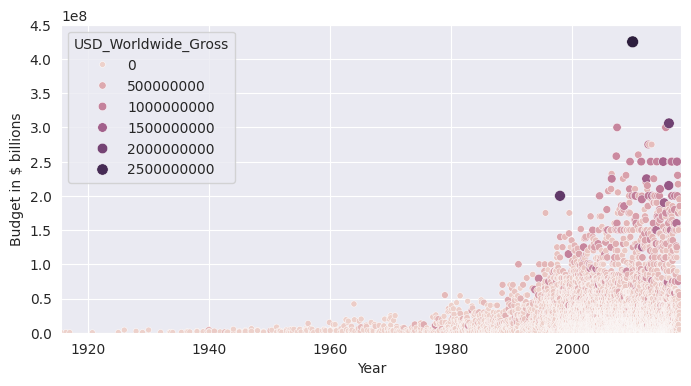

In [27]:
# Make the buble chart above
plt.figure(figsize=(8, 4), dpi=100)

with sns.axes_style("darkgrid"):
    ax = sns.scatterplot(
       data=data_clean,
       x="Release_Date", 
       y="USD_Production_Budget", 
       hue="USD_Worldwide_Gross",
       size="USD_Worldwide_Gross"
    )
ax.set(
    xlim=(data_clean["Release_Date"].min(), data_clean["Release_Date"].max()),
    ylim=(0, 450000000),
    xlabel="Year",
    ylabel="Budget in $ billions"
)
plt.show()

Notice how we are representing 3 dimensions in this chart: the budget, the release date, and the worldwide revenue.

The movie budgets have increased a lot between 1990 and 2018.

# Converting Years to Decades Trick

**Challenge**: Create a column in `data_clean` that has the decade of the release. 

<img src=https://i.imgur.com/0VEfagw.png width=650> 

Here's how: 
1. Create a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column. 
2. Grab all the years from the `DatetimeIndex` object using the `.year` property.
<img src=https://i.imgur.com/5m06Ach.png width=650>
3. Use floor division `//` to convert the year data to the decades of the films.
4. Add the decades as a `Decade` column to the `data_clean` DataFrame.

In [28]:
dt_index = pd.DatetimeIndex(data_clean.loc[:,"Release_Date"].copy())
decades = dt_index.year // 10 * 10
data_clean.insert(loc=0, column="Decade", value=decades)
data_clean[:4]

,Decade,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,USD_Profit
0,1910,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000,10890000
1,1910,5140,1916-05-09,Intolerance,385907,0,0,-385907
2,1910,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000,7800000
3,1920,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000,2900000


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [29]:
old_films = data_clean.query('Decade <= 1960')
new_films = data_clean.query('Decade >= 1970')

print(f"Number of films released prior to 1970 ({old_films.Release_Date.min().year}-{old_films.Release_Date.max().year}):", old_films.shape[0])
print("The most expensive film made prior to 1970: ", old_films.loc[old_films["USD_Production_Budget"].idxmax(),:]["Movie_Title"])

print(f"\nNumber of films released after 1970 ({new_films.Release_Date.min().year}-{new_films.Release_Date.max().year}):", new_films.shape[0])
print("The most expensive film made after 1970: ", new_films.loc[new_films["USD_Production_Budget"].idxmax(),:]["Movie_Title"])

Number of films released prior to 1970 (1915-1969): 153
The most expensive film made prior to 1970:  Cleopatra

Number of films released after 1970 (1970-2017): 5231
The most expensive film made after 1970:  Avatar


# Seaborn Regression Plots

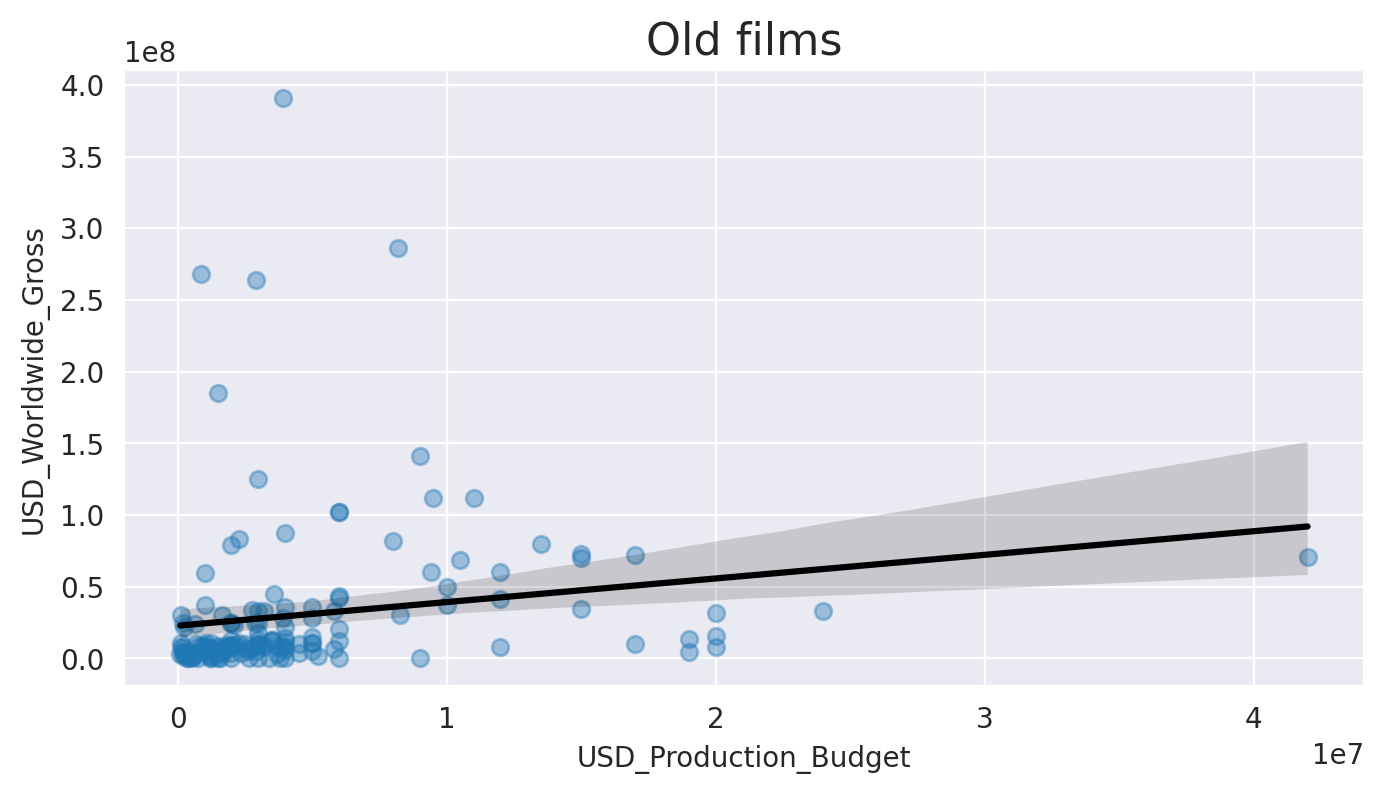

In [30]:
# Visualise the relationship between budget and world wide revenue using linear regression. Seaborn's .regplot() method creates a scatter plot with a linear regression line together with the confindence interval.
plt.figure(figsize=(8, 4), dpi=200)
with sns.axes_style(style="darkgrid"):
    ax = sns.regplot(
        data=old_films,
        x="USD_Production_Budget",
        y="USD_Worldwide_Gross",
        scatter_kws={"alpha": 0.4},  # Transparency of the dots
        line_kws={"color": "black"}
    )
    ax.set_title("Old films", fontdict={"size": 16})
plt.show()

**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`. 
<br><br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* **Do our data points for the new films align better or worse with the linear regression than for our older films?** Yes, the regression line seems to align better with the new movies, compared to the old movies. The confidence interval is also narrower.
* **Roughly how much would a film with a budget of $150 million make according to the regression line?**
According to the regression line, a movie with a budget of $150 million would make almost $0.5 billion.

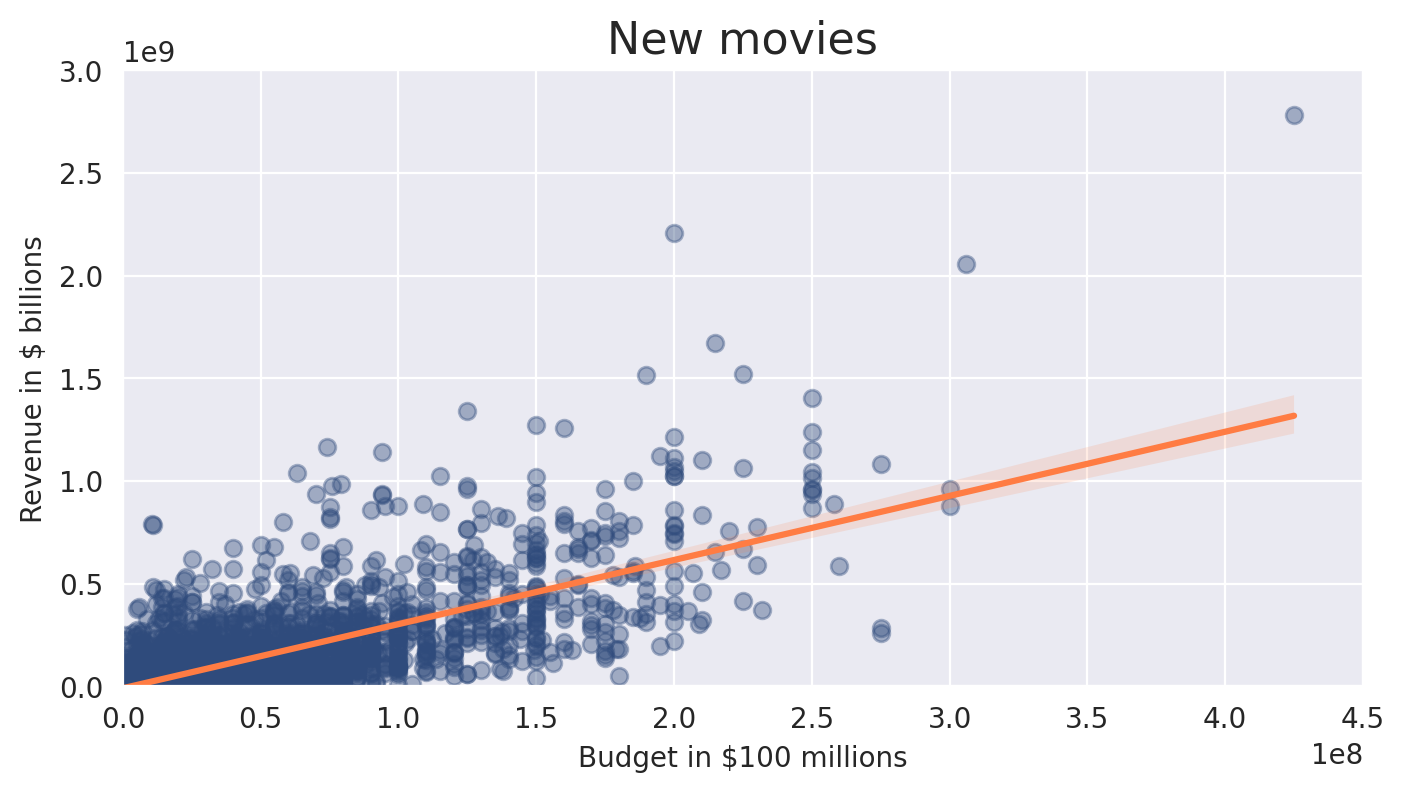

In [31]:
plt.figure(figsize=(8, 4), dpi=200)
with sns.axes_style("darkgrid"):
    ax = sns.regplot(
        data=new_films,
        y="USD_Worldwide_Gross",
        x="USD_Production_Budget",
        scatter_kws={"alpha": 0.4, "color": "#2f4b7c"},
        line_kws={"color": "#ff7c43"}
    )
    ax.set(
        ylim=(0, 3000000000),
        xlim=(0, 450000000),
        ylabel="Revenue in $ billions",
        xlabel="Budget in $100 millions"
    )
    ax.set_title("New movies", size=16)

plt.show()

# Run Your Own Regression with scikit-learn

Using our data on budgets, the linear regression estimates the best possible line to fit our movie revenues. The regression line has the following structure:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$


**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million? 